    Lambda  Task        AA       AIA        FM        IM  Task 0 Acc
0        0     0  0.917143  0.917143  0.000000 -0.035714    0.917143
1        0     1  0.696964  0.807054  0.427143  0.005727    0.490000
2        0     2  0.776071  0.796726  0.195357  0.006802    0.575000
3        0     3  0.722411  0.778147  0.222500  0.034544    0.372857
4        0     4  0.739571  0.770432  0.158571  0.099384    0.717500
5        0     5  0.576964  0.738188  0.340929  0.039123    0.796071
6        0     6  0.473622  0.700392  0.338333  0.592868    0.574643
7       10     0  0.920714  0.920714  0.000000 -0.039286    0.920714
8       10     1  0.768393  0.844554  0.259643  0.033941    0.661071
9       10     2  0.765238  0.818115  0.189643  0.026088    0.721429
10      10     3  0.743036  0.799345  0.170595  0.063830    0.590000
11      10     4  0.638429  0.767162  0.270446  0.084384    0.780357
12      10     5  0.584286  0.736683  0.317429  0.054480    0.843929
13      10     6  0.577908  0.7140

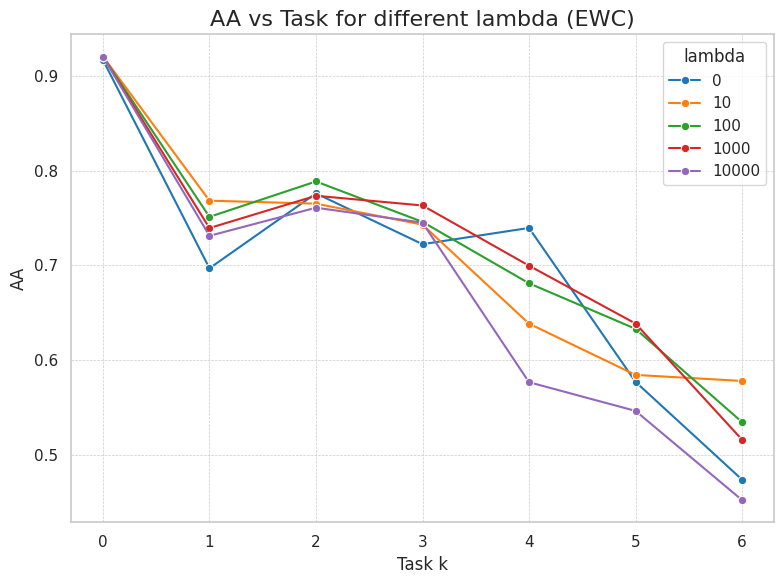

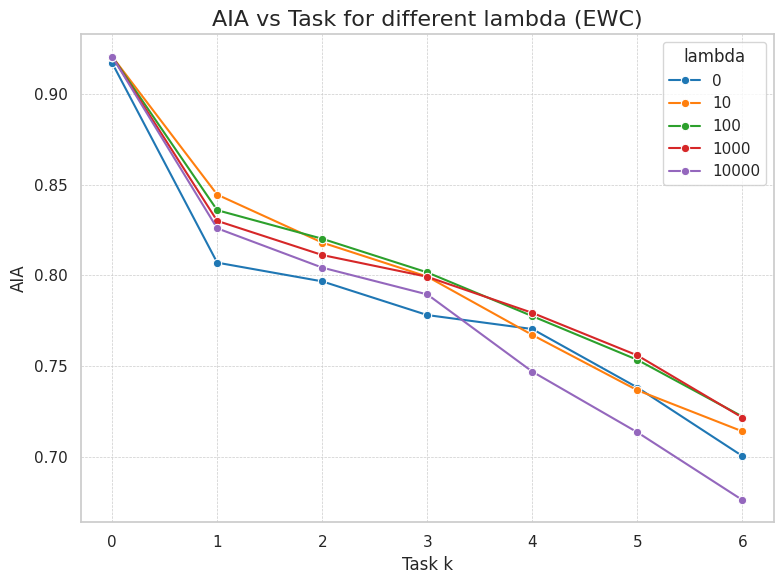

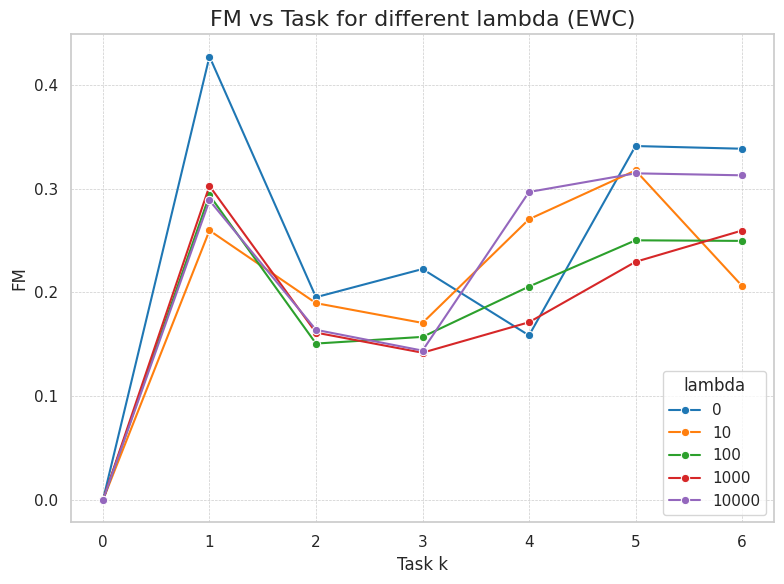

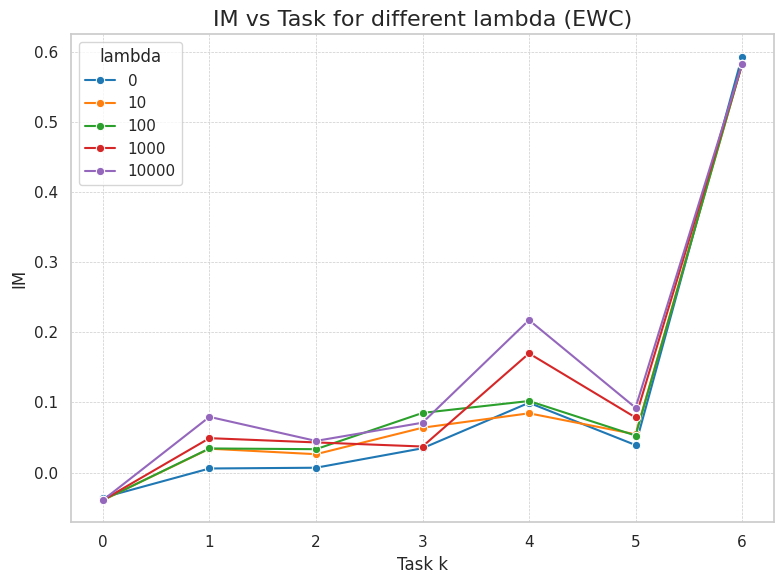

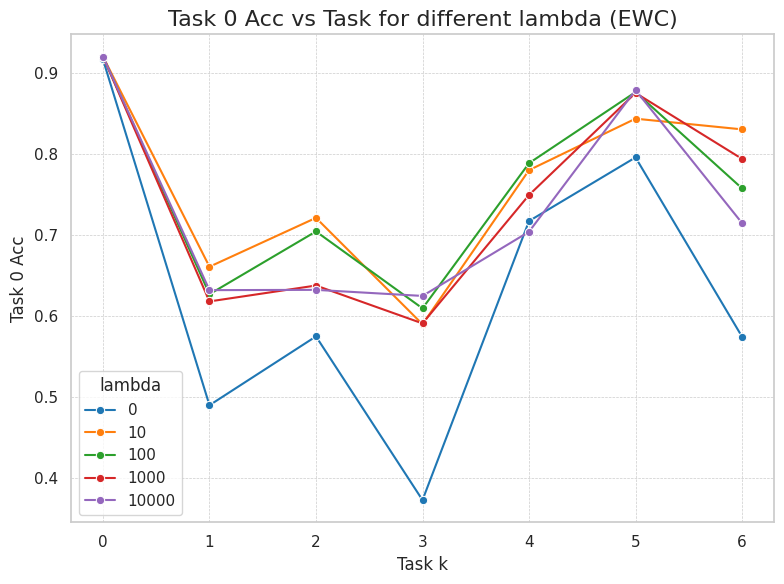

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

# --- 指標計算関数（既存コードを利用） ---
def compute_aa_and_aia(acc_matrix: List[List[float]]):
    AA_list = []
    AIA_list = []
    for k in range(len(acc_matrix)):
        current_accs = acc_matrix[k][:k+1]
        AA_k = sum(current_accs) / len(current_accs)
        AA_list.append(AA_k)
        AIA_k = sum(AA_list) / len(AA_list)
        AIA_list.append(AIA_k)
    return AA_list, AIA_list

def compute_fm(acc_matrix: List[List[float]]):
    num_tasks = len(acc_matrix)
    if num_tasks == 0:
        return []
    fm_list = [0.0]
    for k in range(1, num_tasks):
        forgetting_sum = 0.0
        for j in range(k):
            past_accs = [acc_matrix[l][j] for l in range(j, k)]
            max_past_acc = max(past_accs)
            current_acc = acc_matrix[k][j]
            forgetting_sum += (max_past_acc - current_acc)
        fm_list.append(forgetting_sum / k)
    return fm_list

def compute_im(acc_matrix: List[List[float]], joint_accs: List[float]):
    im_list = []
    for k in range(len(acc_matrix)):
        if k >= len(joint_accs):
            im_list.append(float('nan'))
        else:
            im_list.append(joint_accs[k] - acc_matrix[k][k])
    return im_list

# --- 設定 ---
csv_dir = "/work/csv/uci-har/dil-ewc/"
joint_path = "/work/csv/uci-har/dil-joint//ltc_ncps.csv"
lambda_values = [0, 10, 100, 1000, 10000]  # λスイープ
model_name = "EWC"
num_tasks = 7  

all_metrics = []

for lam in lambda_values:
    file_name = f"lambda{lam}.csv"
    csv_path = os.path.join(csv_dir, file_name)
    
    if not os.path.exists(csv_path) or not os.path.exists(joint_path):
        print(f"CSV missing for λ={lam}, skipping...")
        continue

    df = pd.read_csv(csv_path)
    joint_df = pd.read_csv(joint_path)
    accuracies = df['テスト精度 (Test Acc)'].tolist()
    joint_accuracies = joint_df['テスト精度 (Test Acc)'].tolist()
    
    # acc_matrixを逆三角形に作る
    acc_matrix = []
    pos = 0
    for k in range(num_tasks):
        row = accuracies[pos:pos+k+1]
        acc_matrix.append(row)
        pos += k+1
    
    aa_list, aia_list = compute_aa_and_aia(acc_matrix)
    fm_list = compute_fm(acc_matrix)
    im_list = compute_im(acc_matrix, joint_accuracies)

    for k in range(len(aa_list)):
        all_metrics.append({
            "Lambda": lam,
            "Task": k,
            "AA": aa_list[k],
            "AIA": aia_list[k],
            "FM": fm_list[k],
            "IM": im_list[k],
            "Task 0 Acc": acc_matrix[k][0]
        })

metrics_df = pd.DataFrame(all_metrics)
print(metrics_df)

# --- 可視化 ---
sns.set(style="whitegrid")
metrics_to_plot = ["AA", "AIA", "FM", "IM", "Task 0 Acc"]

# 列名の余計なスペースを除去
metrics_df.rename(columns=lambda x: x.strip(), inplace=True)

for metric in metrics_to_plot:
    plt.figure(figsize=(8,6))
    sns.lineplot(
        data=metrics_df, 
        x="Task", 
        y=metric, 
        hue="Lambda", 
        marker="o", 
        palette="tab10"
    )
    plt.title(f"{metric} vs Task for different lambda (EWC)", fontsize=16)
    plt.xlabel("Task k", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(range(num_tasks))
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(title="lambda")
    plt.tight_layout()
    plt.show()

